# Monitor Every Multiple Steps

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/brainpy/brainpy/blob/master/docs_version2/tutorial_simulation/monitor_per_multiple_steps.ipynb)
[![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/brainpy/brainpy/blob/master/docs_version2/tutorial_simulation/monitor_per_multiple_steps.ipynb)

Sometimes it is not necessary to record the system's behavior at a very high temporal precision. When the simulation time is long, monitoring the variables at high temporal precision can lead to out of memory error. It is very helpful to record the values once every few steps to decrease the memory requirement. 

In this tutorial, we will highlight how to record/monitor variable every multiple simulation time steps. 

In [1]:
import brainpy  as bp
import brainpy .math as bm
import numpy as np

First of all, define your dynamical system that you want. Here we use the EI balanced network model. 

In [2]:
class EINet(bp.DynSysGroup):
  def __init__(self):
    super().__init__()
    self.N = bp.dyn.LifRef(4000, V_rest=-60., V_th=-50., V_reset=-60., tau=20., tau_ref=5.,
                           V_initializer=bp.init.Normal(-55., 2.))
    self.delay = bp.VarDelay(self.N.spike, entries={'I': None})
    self.E = bp.dyn.ProjAlignPostMg1(comm=bp.dnn.EventJitFPHomoLinear(3200, 4000, prob=0.02, weight=0.6),
                                     syn=bp.dyn.Expon.desc(size=4000, tau=5.),
                                     out=bp.dyn.COBA.desc(E=0.),
                                     post=self.N)
    self.I = bp.dyn.ProjAlignPostMg1(comm=bp.dnn.EventJitFPHomoLinear(800, 4000, prob=0.02, weight=6.7),
                                     syn=bp.dyn.Expon.desc(size=4000, tau=10.),
                                     out=bp.dyn.COBA.desc(E=-80.),
                                     post=self.N)

  def update(self, input):
    spk = self.delay.at('I')
    self.E(spk[:3200])
    self.I(spk[3200:])
    self.delay(self.N(input))
    return self.N.spike.value
 
  def run(self, ids, inputs):  # the most import function!!!
    for i, inp in zip(ids, inputs):
      bp.share.save(i=i, t=bm.get_dt() * i)
      self.update(inp)
    return self.N.spike.value

In this example, we monitor the spikes of the neuron group every 1 ms (10 time steps). 

In [3]:
n_step_per_monitor = 10

## ``brainpy.math.for_loop``

The key of using ``brainpy.math.for_loop`` for monitoring at multiple time steps is to reshape the running indices and inputs as the shape of ``[n_time, ..., n_step_per_time]``. 

In [4]:
indices = np.arange(10000).reshape(-1, n_step_per_monitor)
inputs = np.ones(indices.shape) * 20.

Next, we write a run function, in which the model run multiple steps we want. 


```python

class EINet(bp.DynSysGroup):
  ...

  def run(self, ids, inputs):  
    for i, inp in zip(ids, inputs):   # run the model multiple steps in the run function
      bp.share.save(i=i, t=bm.get_dt() * i)
      self.update(inp)
    return self.N.spike.value

```

Finally, let's run the model with ``brainpy.math.for_loop``.

In [5]:
model = EINet()
spks = bm.for_loop(model.run, (indices, inputs), progress_bar=True)
spks.shape

  0%|          | 0/1000 [00:00<?, ?it/s]

(1000, 4000)

The visualization will show what exactly we want.

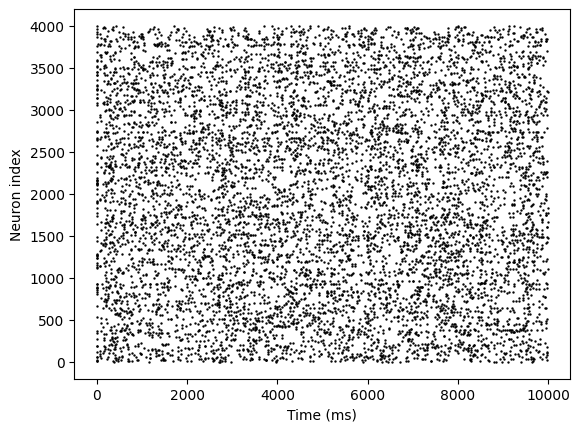

<module 'matplotlib.pyplot' from 'C:\\Users\\adadu\\miniconda3\\envs\\bdp\\Lib\\site-packages\\matplotlib\\pyplot.py'>

In [6]:
bp.visualize.raster_plot(indices[:, 0], spks, show=True)

## ``brainpy.math.jit``

Another way for more flexible monitoring is using ``brainpy.math.jit``.  

From the above example, we see that the drawback of the multi-step monitoring is that it monitors all variables with the same time durations. 
However, sometimes, we try to monitor spikes at every time step, while monitoring membrane potential every ten time steps. For such scenario, ``brainpy.math.jit`` is the more suitable tool. 

In this example, we directly use the jitted step function ``.jit_step_run``. 

In [ ]:
indices = np.arange(10000)
inputs = np.ones(indices.shape) * 20.

model = EINet()

spks = []
mems = []
for i in indices:
    # run the model
    model.jit_step_run(i, inputs[i])
      
    # monitoring
    if i % n_step_per_monitor == 0:  # monitor membrane every ten steps
        mems.append(model.N.V.value)
    spks.append(model.N.spike.value)  # monitor spikes every time
    
spks = bm.as_numpy(spks)
mems = bm.as_numpy(mems)

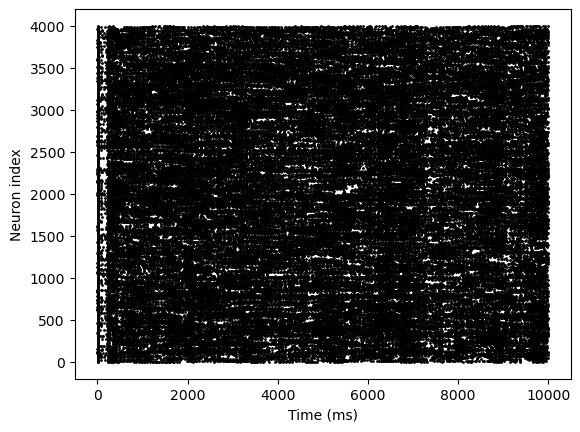

In [8]:
bp.visualize.raster_plot(indices, spks, show=True)

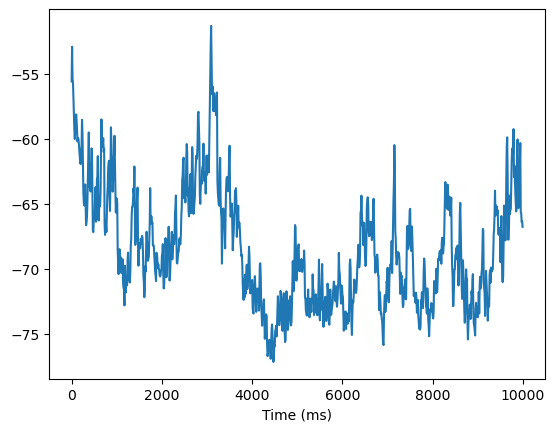

In [14]:
bp.visualize.line_plot(indices[0::n_step_per_monitor], mems, show=True)